# Structure Optimization

In [1]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from potentials import *
from distances import *
from sampling import *

<IPython.core.display.Javascript object>


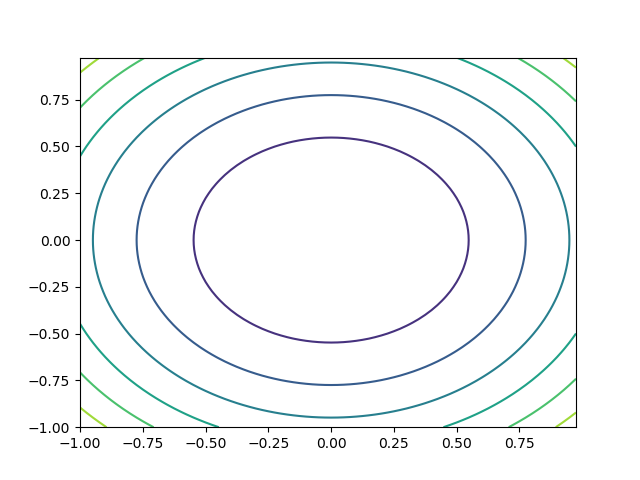

In [3]:
import matplotlib
import matplotlib.cm as cm

delta = 0.025
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-1.0, 1.0, delta)
X, Y = np.meshgrid(x, y)
XY = np.append(X[:, :, None], Y[:, :, None], axis=-1)
Z = potentials.harmonic(XY, [0, 1])

fig, ax = plt.subplots()
ax.contour(X, Y, Z)
#ax.clabel(CS, inline=1, fontsize=10)
#ax.set_title('Simplest default with labels')

In [4]:
def descent( x, a=1e-4, prec=1e-10, maxst=1e6 ):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    
    x = x[None, :, :]
    step = 0
    f = gradients.harmonic( x[-1], [0, 1] )
    x1 = x[-1] - a * f
    
    while(step < maxst and (abs(x[-1] - x1) > prec).all()):
        x = np.append(x, x1[None, :, :], axis=0)
        f = gradients.harmonic( x[-1], [0, 1] )
        x1 = x[-1] - a * f
        step += 1
        
    return x, step

In [6]:
x_init = np.array([[.8, .9], [.2, .3]])
positions, nsteps = descent(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[-1])

# of steps: 14502 | positions.shape: (14503, 2, 2)
[[3.99760832e-07 4.49730936e-07]
 [9.99402080e-08 1.49910312e-07]]


<IPython.core.display.Javascript object>


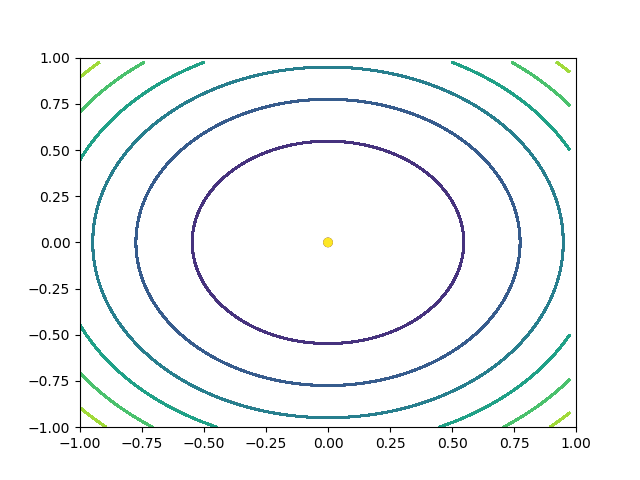

In [7]:
from matplotlib import animation


#import matplotlib.cm as cm
#delta = 0.025
#x = np.arange(-3.0, 3.0, delta)
#y = np.arange(-3.0, 3.0, delta)
#X, Y = np.meshgrid(x, y)
#XY = np.append(X[:, :, None], Y[:, :, None], axis=-1)
#Z = potentials.harmonic(XY, [0, 1])
fig, ax = plt.subplots()
#ax.contour(X, Y, Z)

#fig, ax = plt.subplots(figsize=(8, 8))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=colors)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
def animate(i):
    index = 100*i
    data = positions[index]
    scat.set_offsets(data)
    ax.contour(X, Y, Z)
    return scat

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=25, bitrate=1800)
anim = animation.FuncAnimation(fig, animate, interval=1)#, frames=750, repeat=False)
#anim.save('LJ_Harmonic_Particles.mp4', writer=writer)

In [8]:
def dist_torch(x): 
    """Calculates distance vectors and distances (euclidian norm of vecs)
    
    Arguments:
        x (float): position vectors (dim = N x 3)
    
    Output:
        dist (float): distances between particle pairs (dim = N x N)
        vecs (float): distance vectors between particle pairs (dim = N x N x 3)
    """
    x = torch.Tensor(x)
    vecs = x[None, :, :] - x[:, None, :]       
    return torch.norm(vecs, dim=-1), vecs

def gradLJ(vecs, sig=1, eps=1):
        dist = dist_torch(vecs)[0].numpy()
        dist[dist!=0] = 1/dist[dist!=0]
        D_att = 6 * sig**6 * dist**8
        D_rep = -12 * sig**12 * dist**14
        D = 4*(eps*(D_att + D_rep))[:, :, None]*vecs
        return np.sum(D, axis=-2)
    
def descent_h_lj( x, a=1e-4, prec=1e-10, maxst=1e6 ):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    
    x = x[None, :, :]
    step = 0
    f = gradients.harmonic(x[-1], [0, 1]) + gradLJ(x[-1])
    #f = gradients.harmonic(x[-1], [0, 1]) + gradients.LJ(x[-1])
    x1 = x[-1] - a * f
    
    while(step < maxst and (abs(x[-1] - x1) > prec).all()):
        x = np.append(x, x1[None, :, :], axis=0)
        f = gradients.harmonic(x[-1], [0, 1]) + gradLJ(x[-1]) 
        #f = gradients.harmonic(x[-1], [0, 1]) + gradients.LJ(x[-1])
        x1 = x[-1] - a * f
        step += 1
        
    return x, step

In [12]:
x_init = np.array([[-1., -1e-5], [1., 1e-5]])*2.9
print(np.append(x_init[None, :, :],x_init[None, :, :], axis=0))
positions, nsteps = descent_h_lj(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[1])
print(positions[-1])

[[[-2.9e+00 -2.9e-05]
  [ 2.9e+00  2.9e-05]]

 [[-2.9e+00 -2.9e-05]
  [ 2.9e+00  2.9e-05]]]
# of steps: 2029 | positions.shape: (2030, 2, 2)
[[-2.89710005e+00 -2.89710005e-05]
 [ 2.89710005e+00  2.89710005e-05]]
[[-7.2238452e-01 -7.2238452e-06]
 [ 7.2238452e-01  7.2238452e-06]]


# of steps: 2029 | positions.shape: (2030, 2, 2)
[[-2.89710005e+00 -2.89710005e-05]
 [ 2.89710005e+00  2.89710005e-05]]
[[-7.2238452e-01 -7.2238452e-06]
 [ 7.2238452e-01  7.2238452e-06]]


<IPython.core.display.Javascript object>


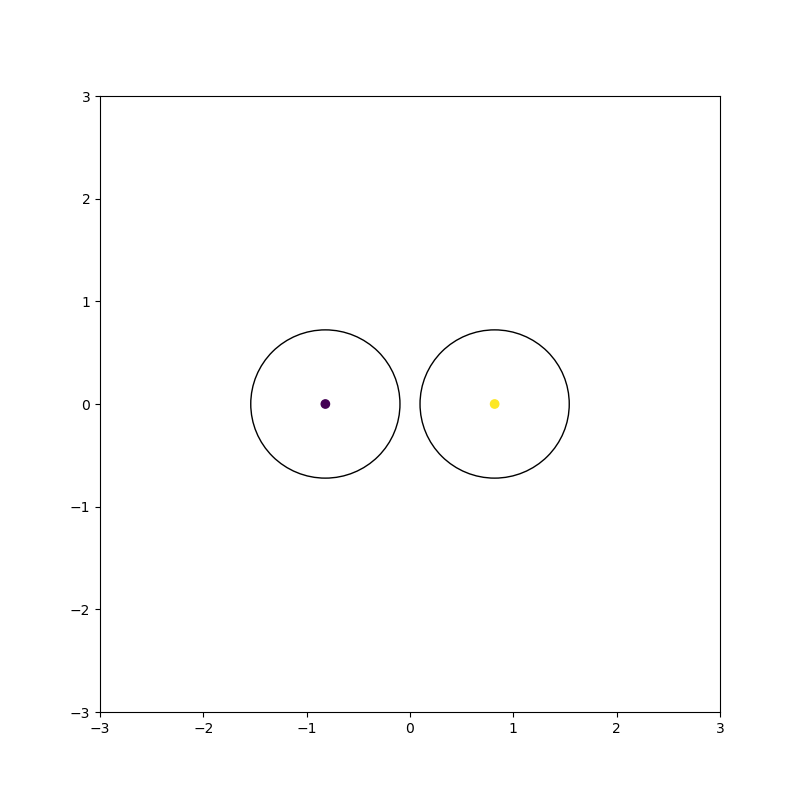

In [10]:
x_init = np.array([[-1., -1e-5], [1., 1e-5]])*2.9
positions, nsteps = descent_h_lj(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[1])
print(positions[-1])

fig, ax = plt.subplots(figsize=(8, 8))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=colors)
circles = [plt.Circle(r, radius=0.722, fill=False) 
            for i,r in enumerate(x_init)]
for c in circles:
    plt.gca().add_patch(c)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
def animate(i):
    index = i
    data = positions[index]
    scat.set_offsets(data)
    for i, c in enumerate(circles):
        c.center = data[i]
    return scat

anim = animation.FuncAnimation(fig, animate, interval=1)

In [11]:
x_init = np.array([[-1., 0], [1.2, -0]])*2.9
positions, nsteps = descent_h_lj(x_init, 1e-3)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[1])
print(positions[-1])

# of steps: 0 | positions.shape: (1, 2, 2)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [13]:
import random

def Random_particles( N, dim=3 ):
    """Creates a list of N particles with random positions and charges
    
    Arguments:
        N (int): number of particles
        
    Output:
        x (float): position vectors (dim = N x 3)
        q (int): charges (dim = N)
    """
    return np.random.rand(N, dim), np.array([[-1, 1][random.randrange(2)] for i in range(N)])

# of steps: 85687 | positions.shape: (85688, 2, 2)
[[7.77503768 4.80889748]
 [7.65408452 8.36530286]]
[[ 0.02450064 -0.72037563]
 [-0.02449927  0.7203768 ]]


<IPython.core.display.Javascript object>


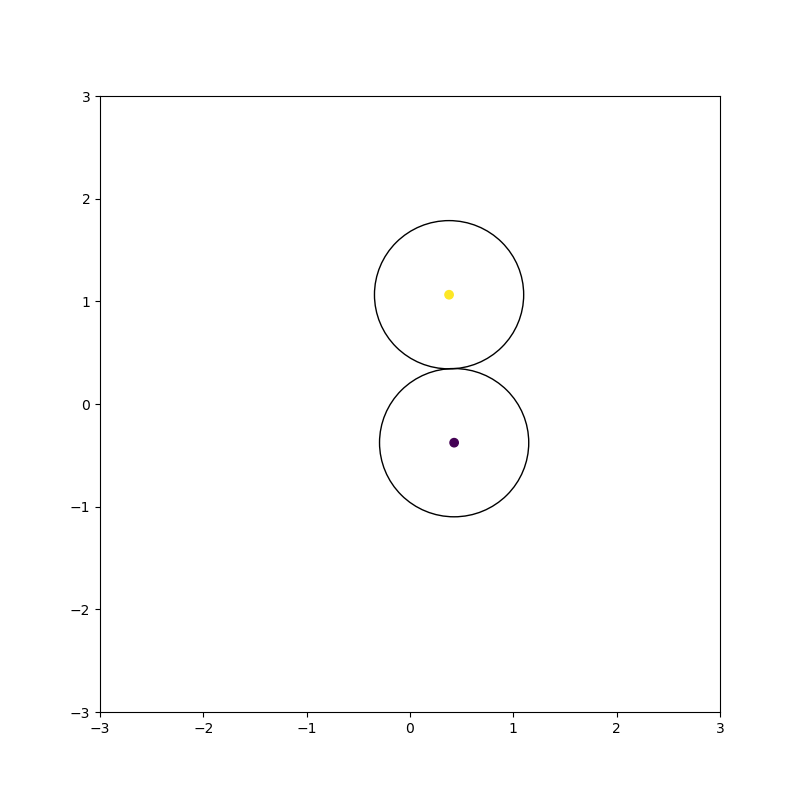

In [14]:
N = 2
dim = 2

x_init, q = Random_particles(N, dim)
x_init *= 10
positions, nsteps = descent_h_lj(x_init)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print(positions[0])
print(positions[-1])

fig, ax = plt.subplots(figsize=(8, 8))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=colors)
circles = [plt.Circle(r, radius=0.722, fill=False) 
            for i,r in enumerate(x_init)]
for c in circles:
    plt.gca().add_patch(c)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
def animate(i):
    index = 10*i
    data = positions[index]
    scat.set_offsets(data)
    for i, c in enumerate(circles):
        c.center = data[i]
    return scat

anim = animation.FuncAnimation(fig, animate, interval=1)